## Imports

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crzas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\crzas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\crzas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Pre-Processing

In [2]:
# Read in the data and add columns to the dataframe
book_summs = pd.read_csv('data/booksummaries.txt', header=None, sep='\t')
book_summs.columns = ['wikipedia_article_id', 'freebase_id', 'title', 'author', 'pub_date', 'genre', 'summary']

# Remove extraneous features - freebase_id, author, pub_date
book_summs = book_summs.drop(labels=['freebase_id', 'author', 'pub_date'], axis=1)
print(book_summs.head())

   wikipedia_article_id                                      title  \
0                   620                                Animal Farm   
1                   843                         A Clockwork Orange   
2                   986                                 The Plague   
3                  1756  An Enquiry Concerning Human Understanding   
4                  2080                       A Fire Upon the Deep   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                NaN   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of th

In [3]:
# example code taken from fast-bert
def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def clean_text(input_text):
    text = replace_multi_newline(input_text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

In [4]:
print('Size of dataset before preprocessing:', len(book_summs))

# Remove any books which don't have genres
book_summs.dropna(subset=['genre'], inplace=True)

print('Size of dataset after removing missing genres:', len(book_summs))

# Remove any books which don't have titles
book_summs.dropna(subset=['title'], inplace=True)

print('Size of dataset after removing missing titles:', len(book_summs))

# Remove any books which don't have summaries
book_summs.dropna(subset=['summary'], inplace=True)

print('Size of dataset after removing missing summaries:', len(book_summs))
print('Size of dataset after preprocessing:', len(book_summs))

# Tokenize titles & convert to lower case - add to tokenized_title column
book_summs['tokenized_title'] = book_summs['title'].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))

# Tokenize summaries & convert to lower case - add to tokenized_summary column
book_summs['tokenized_summary'] = book_summs['summary'].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))

# Remove all stop words from all summaries & titles
stop = stopwords.words('english')
book_summs['tokenized_summary'] = book_summs['tokenized_summary'].apply(lambda x: [word for word in x if word not in (stop)])
book_summs['tokenized_title'] = book_summs['tokenized_title'].apply(lambda x: [word for word in x if word not in (stop)])

print(book_summs.head())

Size of dataset before preprocessing: 16559
Size of dataset after removing missing genres: 12841
Size of dataset after removing missing titles: 12841
Size of dataset after removing missing summaries: 12841
Size of dataset after preprocessing: 12841
   wikipedia_article_id                           title  \
0                   620                     Animal Farm   
1                   843              A Clockwork Orange   
2                   986                      The Plague   
4                  2080            A Fire Upon the Deep   
5                  2152  All Quiet on the Western Front   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   
5  {"/m/098tmk": "War novel", "/m/016lj8": "Roman...   

                                             summary       

In [5]:
# Format the genre field
formatted_genres = []
genre_dict = dict()
for g in book_summs['genre']:
    subg = []
    genre_dict = eval(g)
    for k in genre_dict.keys():
        subg.append(genre_dict[k])
    formatted_genres.append(subg)
book_summs['formatted_genre'] = formatted_genres
print(book_summs.head())

   wikipedia_article_id                           title  \
0                   620                     Animal Farm   
1                   843              A Clockwork Orange   
2                   986                      The Plague   
4                  2080            A Fire Upon the Deep   
5                  2152  All Quiet on the Western Front   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   
5  {"/m/098tmk": "War novel", "/m/016lj8": "Roman...   

                                             summary          tokenized_title  \
0   Old Major, the old boar on the Manor Farm, ca...           [animal, farm]   
1   Alex, a teenager living in near-future Englan...      [clockwork, orange]   
2   The text of The Plague is divided into five p...             

In [6]:
genres = set()
for x in book_summs['formatted_genre']:
    genres.update(x)

new_columns = list(genres)
default_value = 0
book_summs = pd.concat([book_summs, pd.DataFrame({col: default_value for col in new_columns}, index=book_summs.index)], axis=1)
book_summs = book_summs.drop(labels=['title', 'genre', 'summary'], axis=1)

In [7]:
for index,row in book_summs.iterrows():
    for g in row['formatted_genre']:
        book_summs.at[index, g] = 1

## Exploratory Data Analysis

In [8]:
print('# of unique genres:', len(genres))

# of unique genres: 227


Genre distribution: {5: 653, 6: 258, 4: 1428, 2: 3532, 1: 4555, 3: 2275, 9: 11, 7: 101, 8: 26, 11: 1, 10: 1}


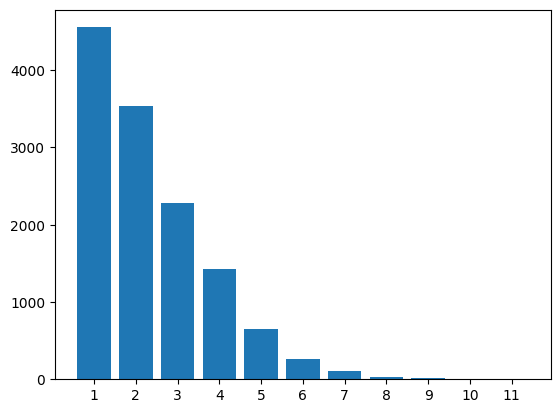

In [9]:
genre_dist = dict()
for x in book_summs['formatted_genre']:
    if len(x) in genre_dist.keys():
        genre_dist[len(x)] += 1
    else:
        genre_dist[len(x)] = 1

print("Genre distribution:", genre_dist)

plt.bar(range(len(genre_dist)), sorted(genre_dist.values(), reverse=True), align='center')
plt.xticks(range(len(genre_dist)), sorted(list(genre_dist.keys())))

plt.show()

In [10]:
top_genre = dict()
for x in book_summs['formatted_genre']:
    for g in x:
        if g in top_genre.keys():
            top_genre[g] += 1
        else:
            top_genre[g] = 1
sorted_genre = sorted(top_genre.items(), key=lambda item: item[1], reverse=True)
print(sorted_genre[:20])

[('Fiction', 4747), ('Speculative fiction', 4314), ('Science Fiction', 2870), ('Novel', 2463), ('Fantasy', 2413), ("Children's literature", 2122), ('Mystery', 1396), ('Young adult literature', 825), ('Suspense', 765), ('Crime Fiction', 753), ('Historical novel', 654), ('Thriller', 568), ('Horror', 511), ('Romance novel', 435), ('Historical fiction', 388), ('Detective fiction', 341), ('Adventure novel', 330), ('Non-fiction', 230), ('Alternate history', 226), ('Spy fiction', 190)]


## Classification

In [11]:
class_df = book_summs.drop(labels=['formatted_genre'], axis=1)
print(class_df.columns)

Index(['wikipedia_article_id', 'tokenized_title', 'tokenized_summary',
       'Novella', 'Scientific romance', 'Fiction', 'Dying Earth subgenre',
       'Gay novel', 'Pastiche', 'Experimental literature',
       ...
       'Roman à clef', 'Postmodernism', 'Conspiracy', 'Edisonade',
       'Existentialism', 'Inspirational', 'Magic realism', 'Personal journal',
       'Social novel', 'Picture book'],
      dtype='object', length=230)


In [12]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""
    
    def __init__(self, guid, text_a, text_b, labels=None):
        """
            Constructs an InputExample
            
            Args:
                guid: Unique id for the example
                text_a: string. The untokenized text of the first sequence.
                text_b: string. The untokenized text of the second sequence.
                labels: (Optional) [string]. The label of the example. This
                    should be specified for train and dev examples, but not
                    for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels

In [13]:
def create_examples(df, labels_available=True):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, row) in enumerate(df.values):
        guid = row[0]
        text_a = row[1]
        text_b = row[2]
        if labels_available:
            labels = row[3:]
        else:
            labels = [0] * 227
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, labels=labels))
    return examples